# Анализ данных социальных сетей: Мнение о медицине в РФ

## Курсовая работа
**Тема:** Анализ данных социальных сетей с использованием больших данных и машинного обучения

**Цель:** Проанализировать мнение пользователей ВКонтакте о медицине в РФ за последние 5 лет на основе данных паблика Минздрава России

**Источник данных:** Паблик Минздрава России (vk.com/minzdravru)

**Период анализа:** 2020-2025 (5 лет)

---

## ⚠️ ВАЖНО: Порядок выполнения ячеек

**Для корректной работы ноутбука необходимо выполнять ячейки ПОСЛЕДОВАТЕЛЬНО сверху вниз:**

1. **Ячейки 1-3:** Импорт библиотек и загрузка данных
2. **Ячейка 4:** Преобразование дат
3. **Ячейки 5-7:** Базовый статистический анализ
4. **Ячейка 9:** Предобработка текста
5. **Ячейка 10:** Сентимент-анализ (ОБЯЗАТЕЛЬНО перед анализом по годам!)
6. **Ячейка 13:** Анализ динамики по годам
7. **Остальные ячейки:** Дополнительные анализы

**Рекомендация:** Используйте `Kernel → Restart & Run All` для запуска всех ячеек по порядку.


## 1. Импорт библиотек и загрузка данных


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Настройка для отображения русских шрифтов
plt.rcParams['font.family'] = ['Arial Unicode MS', 'DejaVu Sans', 'sans-serif']
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Настройка pandas для отображения всех колонок
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.width', None)


In [45]:
# Загрузка данных (объединенные файлы за все 5 лет)
import glob
import os

# Проверка наличия файлов
posts_files = glob.glob('data/vk_data_ALL_POSTS_*.csv')
comments_files = glob.glob('data/vk_data_ALL_COMMENTS_*.csv')

if not posts_files:
    raise FileNotFoundError("Ошибка: Не найдены файлы с постами в папке data/. Убедитесь, что файлы vk_data_ALL_POSTS_*.csv существуют.")
if not comments_files:
    raise FileNotFoundError("Ошибка: Не найдены файлы с комментариями в папке data/. Убедитесь, что файлы vk_data_ALL_COMMENTS_*.csv существуют.")

posts_file = posts_files[0]
comments_file = comments_files[0]

print(f"Загрузка данных из файлов:")
print(f"  Посты: {posts_file}")
print(f"  Комментарии: {comments_file}")
print()

posts_df = pd.read_csv(posts_file, encoding='utf-8-sig')
comments_df = pd.read_csv(comments_file, encoding='utf-8-sig')

print(f"✅ Загружено постов: {len(posts_df):,}")
print(f"✅ Загружено комментариев: {len(comments_df):,}")
print(f"\nКолонки в постах: {list(posts_df.columns)}")
print(f"Колонки в комментариях: {list(comments_df.columns)}")


Загрузка данных из файлов:
  Посты: data/vk_data_ALL_POSTS_20251130_232611.csv
  Комментарии: data/vk_data_ALL_COMMENTS_20251130_232611.csv

✅ Загружено постов: 6,658
✅ Загружено комментариев: 51,800

Колонки в постах: ['post_id', 'target_id', 'owner_id', 'date', 'date_timestamp', 'text', 'text_length', 'likes', 'reposts', 'comments_count', 'views', 'engagement']
Колонки в комментариях: ['comment_id', 'post_id', 'target_id', 'owner_id', 'date', 'date_timestamp', 'text', 'text_length', 'likes', 'author_id']


In [46]:
# Преобразование дат
posts_df['date'] = pd.to_datetime(posts_df['date'])
comments_df['date'] = pd.to_datetime(comments_df['date'])

# Извлечение года и месяца
posts_df['year'] = posts_df['date'].dt.year
posts_df['month'] = posts_df['date'].dt.month
posts_df['year_month'] = posts_df['date'].dt.to_period('M')

comments_df['year'] = comments_df['date'].dt.year
comments_df['month'] = comments_df['date'].dt.month
comments_df['year_month'] = comments_df['date'].dt.to_period('M')

print(f"Период постов: {posts_df['date'].min()} - {posts_df['date'].max()}")
print(f"Период комментариев: {comments_df['date'].min()} - {comments_df['date'].max()}")


Период постов: 2020-01-07 14:23:28 - 2025-11-30 14:43:42
Период комментариев: 2020-07-07 20:27:21 - 2025-11-30 20:39:33


## 2. Очистка и предобработка данных


In [47]:
# 2.1. Анализ качества данных ДО очистки
print("=" * 70)
print("АНАЛИЗ КАЧЕСТВА ДАННЫХ ДО ОЧИСТКИ")
print("=" * 70)

print(f"\n📊 ПОСТЫ:")
print(f"   Всего записей: {len(posts_df):,}")
print(f"   Дубликаты: {posts_df.duplicated(subset=['post_id']).sum():,}")
print(f"   Пропуски в тексте: {posts_df['text'].isna().sum():,}")
print(f"   Пустые тексты: {(posts_df['text'].astype(str).str.strip() == '').sum():,}")
print(f"   Очень короткие тексты (<10 символов): {(posts_df['text_length'] < 10).sum():,}")

print(f"\n📊 КОММЕНТАРИИ:")
print(f"   Всего записей: {len(comments_df):,}")
print(f"   Дубликаты: {comments_df.duplicated(subset=['comment_id']).sum():,}")
print(f"   Пропуски в тексте: {comments_df['text'].isna().sum():,}")
print(f"   Пустые тексты: {(comments_df['text'].astype(str).str.strip() == '').sum():,}")
print(f"   Очень короткие тексты (<3 символов): {(comments_df['text_length'] < 3).sum():,}")

# Сохраняем исходное количество для сравнения
initial_posts_count = len(posts_df)
initial_comments_count = len(comments_df)


АНАЛИЗ КАЧЕСТВА ДАННЫХ ДО ОЧИСТКИ

📊 ПОСТЫ:
   Всего записей: 6,658
   Дубликаты: 0
   Пропуски в тексте: 138
   Пустые тексты: 0
   Очень короткие тексты (<10 символов): 138

📊 КОММЕНТАРИИ:
   Всего записей: 51,800
   Дубликаты: 0
   Пропуски в тексте: 4,569
   Пустые тексты: 0
   Очень короткие тексты (<3 символов): 5,080


In [48]:
# 2.2. Очистка данных от дубликатов
print("\n" + "=" * 70)
print("ОЧИСТКА ОТ ДУБЛИКАТОВ")
print("=" * 70)

# Удаление дубликатов постов
posts_before = len(posts_df)
posts_df = posts_df.drop_duplicates(subset=['post_id'], keep='first')
posts_removed = posts_before - len(posts_df)
print(f"Посты: удалено {posts_removed:,} дубликатов (было {posts_before:,}, стало {len(posts_df):,})")

# Удаление дубликатов комментариев
comments_before = len(comments_df)
comments_df = comments_df.drop_duplicates(subset=['comment_id'], keep='first')
comments_removed = comments_before - len(comments_df)
print(f"Комментарии: удалено {comments_removed:,} дубликатов (было {comments_before:,}, стало {len(comments_df):,})")



ОЧИСТКА ОТ ДУБЛИКАТОВ
Посты: удалено 0 дубликатов (было 6,658, стало 6,658)
Комментарии: удалено 0 дубликатов (было 51,800, стало 51,800)


In [49]:
# 2.3. Очистка от пропусков и пустых значений
print("\n" + "=" * 70)
print("ОЧИСТКА ОТ ПРОПУСКОВ И ПУСТЫХ ЗНАЧЕНИЙ")
print("=" * 70)

# Посты: удаляем записи с пустым или очень коротким текстом
posts_before = len(posts_df)
posts_df = posts_df[posts_df['text'].notna()]
posts_df = posts_df[posts_df['text'].astype(str).str.strip() != '']
posts_df = posts_df[posts_df['text_length'] >= 10]  # Минимум 10 символов
posts_removed = posts_before - len(posts_df)
print(f"Посты: удалено {posts_removed:,} записей с пустым/коротким текстом (осталось {len(posts_df):,})")

# Комментарии: удаляем записи с пустым или очень коротким текстом
comments_before = len(comments_df)
comments_df = comments_df[comments_df['text'].notna()]
comments_df = comments_df[comments_df['text'].astype(str).str.strip() != '']
comments_df = comments_df[comments_df['text_length'] >= 3]  # Минимум 3 символа
comments_removed = comments_before - len(comments_df)
print(f"Комментарии: удалено {comments_removed:,} записей с пустым/коротким текстом (осталось {len(comments_df):,})")



ОЧИСТКА ОТ ПРОПУСКОВ И ПУСТЫХ ЗНАЧЕНИЙ
Посты: удалено 138 записей с пустым/коротким текстом (осталось 6,520)
Комментарии: удалено 5,080 записей с пустым/коротким текстом (осталось 46,720)


In [50]:
# 2.4. Функция предобработки текста
def preprocess_text(text):
    """
    Предобработка текста для анализа:
    - Удаление URL
    - Удаление упоминаний и хештегов
    - Удаление лишних пробелов
    - Удаление спецсимволов
    - Приведение к нижнему регистру
    """
    if pd.isna(text) or not text:
        return ""
    
    text = str(text)
    
    # Удаляем URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Удаляем упоминания и хештеги
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    
    # Удаляем спецсимволы, оставляем только буквы, цифры и пробелы
    text = re.sub(r'[^\w\s]', '', text)
    
    return text.strip().lower()

print("\n" + "=" * 70)
print("ПРЕДОБРАБОТКА ТЕКСТА")
print("=" * 70)

# Применяем предобработку к постам
print("\n📝 Обработка текстов постов...")
posts_df['text_processed'] = posts_df['text'].apply(preprocess_text)
posts_df['text_processed_length'] = posts_df['text_processed'].str.len()

# Применяем предобработку к комментариям
print("📝 Обработка текстов комментариев...")
comments_df['text_processed'] = comments_df['text'].apply(preprocess_text)
comments_df['text_processed_length'] = comments_df['text_processed'].str.len()

print("✅ Предобработка завершена")



ПРЕДОБРАБОТКА ТЕКСТА

📝 Обработка текстов постов...
📝 Обработка текстов комментариев...
✅ Предобработка завершена


In [51]:
# 2.5. Примеры до и после предобработки
print("\n" + "=" * 70)
print("ПРИМЕРЫ ПРЕДОБРАБОТКИ ТЕКСТА")
print("=" * 70)

print("\n📋 ПРИМЕРЫ ПОСТОВ:")
print("-" * 70)
for idx in range(min(3, len(posts_df))):
    original = str(posts_df.iloc[idx]['text'])[:150] + "..." if len(str(posts_df.iloc[idx]['text'])) > 150 else str(posts_df.iloc[idx]['text'])
    processed = posts_df.iloc[idx]['text_processed'][:150] + "..." if len(posts_df.iloc[idx]['text_processed']) > 150 else posts_df.iloc[idx]['text_processed']
    print(f"\nПример {idx + 1}:")
    print(f"  Оригинал: {original}")
    print(f"  Обработан: {processed}")

print("\n📋 ПРИМЕРЫ КОММЕНТАРИЕВ:")
print("-" * 70)
for idx in range(min(3, len(comments_df))):
    original = str(comments_df.iloc[idx]['text'])[:150] + "..." if len(str(comments_df.iloc[idx]['text'])) > 150 else str(comments_df.iloc[idx]['text'])
    processed = comments_df.iloc[idx]['text_processed'][:150] + "..." if len(comments_df.iloc[idx]['text_processed']) > 150 else comments_df.iloc[idx]['text_processed']
    print(f"\nПример {idx + 1}:")
    print(f"  Оригинал: {original}")
    print(f"  Обработан: {processed}")



ПРИМЕРЫ ПРЕДОБРАБОТКИ ТЕКСТА

📋 ПРИМЕРЫ ПОСТОВ:
----------------------------------------------------------------------

Пример 1:
  Оригинал: Посещение медицинских учреждений в Рождество Патриархом Московским и Всея Руси Кириллом и Министром здравоохранения РФ Вероникой Скворцовой стало трад...
  Обработан: посещение медицинских учреждений в рождество патриархом московским и всея руси кириллом и министром здравоохранения рф вероникой скворцовой стало трад...

Пример 2:
  Оригинал: Ярославский областной  онкоцентр впервые принимал пациентов в праздничные дни. 

Для повышения доступности онкологической помощи населению, департамен...
  Обработан: ярославский областной онкоцентр впервые принимал пациентов в праздничные дни для повышения доступности онкологической помощи населению департамент здр...

Пример 3:
  Оригинал: #НацПроектЗдравоохранение
  Обработан: 

📋 ПРИМЕРЫ КОММЕНТАРИЕВ:
----------------------------------------------------------------------

Пример 1:
  Оригинал: Вы бы его 

In [52]:
# 2.6. Итоговая статистика после очистки
print("\n" + "=" * 70)
print("ИТОГОВАЯ СТАТИСТИКА ПОСЛЕ ОЧИСТКИ И ПРЕДОБРАБОТКИ")
print("=" * 70)

print(f"\n📊 ПОСТЫ:")
print(f"   Было записей: {initial_posts_count:,}")
print(f"   Стало записей: {len(posts_df):,}")
print(f"   Удалено: {initial_posts_count - len(posts_df):,} ({(initial_posts_count - len(posts_df))/initial_posts_count*100:.1f}%)")
print(f"   Средняя длина текста (оригинал): {posts_df['text_length'].mean():.1f} символов")
print(f"   Средняя длина текста (обработан): {posts_df['text_processed_length'].mean():.1f} символов")

print(f"\n📊 КОММЕНТАРИИ:")
print(f"   Было записей: {initial_comments_count:,}")
print(f"   Стало записей: {len(comments_df):,}")
print(f"   Удалено: {initial_comments_count - len(comments_df):,} ({(initial_comments_count - len(comments_df))/initial_comments_count*100:.1f}%)")
print(f"   Средняя длина текста (оригинал): {comments_df['text_length'].mean():.1f} символов")
print(f"   Средняя длина текста (обработан): {comments_df['text_processed_length'].mean():.1f} символов")

print(f"\n✅ Данные готовы к анализу!")



ИТОГОВАЯ СТАТИСТИКА ПОСЛЕ ОЧИСТКИ И ПРЕДОБРАБОТКИ

📊 ПОСТЫ:
   Было записей: 6,658
   Стало записей: 6,520
   Удалено: 138 (2.1%)
   Средняя длина текста (оригинал): 1275.7 символов
   Средняя длина текста (обработан): 1192.0 символов

📊 КОММЕНТАРИИ:
   Было записей: 51,800
   Стало записей: 46,720
   Удалено: 5,080 (9.8%)
   Средняя длина текста (оригинал): 259.9 символов
   Средняя длина текста (обработан): 246.1 символов

✅ Данные готовы к анализу!


## 3. Сентимент-анализ комментариев 


In [53]:
print("=" * 60)
print("БАЗОВАЯ СТАТИСТИКА ПОСТОВ")
print("=" * 60)
print(f"Всего постов: {len(posts_df):,}")
print(f"Среднее количество лайков: {posts_df['likes'].mean():.2f}")
print(f"Медианное количество лайков: {posts_df['likes'].median():.2f}")
print(f"Максимальное количество лайков: {posts_df['likes'].max()}")
print(f"\nСреднее количество репостов: {posts_df['reposts'].mean():.2f}")
print(f"Среднее количество комментариев: {posts_df['comments_count'].mean():.2f}")
print(f"Средний engagement: {posts_df['engagement'].mean():.2f}")
print(f"Средняя длина текста: {posts_df['text_length'].mean():.2f} символов")
print(f"\nВсего просмотров (если доступно): {posts_df['views'].sum():,}")


БАЗОВАЯ СТАТИСТИКА ПОСТОВ
Всего постов: 6,520
Среднее количество лайков: 168.61
Медианное количество лайков: 97.00
Максимальное количество лайков: 7427

Среднее количество репостов: 38.40
Среднее количество комментариев: 25.82
Средний engagement: 232.83
Средняя длина текста: 1275.74 символов

Всего просмотров (если доступно): 1,091,808,368


In [54]:
print("=" * 60)
print("БАЗОВАЯ СТАТИСТИКА КОММЕНТАРИЕВ")
print("=" * 60)
print(f"Всего комментариев: {len(comments_df):,}")
print(f"Среднее количество лайков на комментарий: {comments_df['likes'].mean():.2f}")
print(f"Максимальное количество лайков на комментарий: {comments_df['likes'].max()}")
print(f"Средняя длина комментария: {comments_df['text_length'].mean():.2f} символов")
print(f"Уникальных авторов комментариев: {comments_df['author_id'].nunique():,}")


БАЗОВАЯ СТАТИСТИКА КОММЕНТАРИЕВ
Всего комментариев: 46,720
Среднее количество лайков на комментарий: 3.92
Максимальное количество лайков на комментарий: 635
Средняя длина комментария: 259.92 символов
Уникальных авторов комментариев: 14,385


In [ ]:
def preprocess_text(text):
    """Предобработка текста"""
    if pd.isna(text) or not text:
        return ""
    text = str(text)
    # Удаляем URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Удаляем упоминания
    text = re.sub(r'@\w+|#\w+', '', text)
    # Удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    # Удаляем спецсимволы, оставляем только буквы, цифры и пробелы
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip().lower()

# Применяем предобработку
comments_df['text_processed'] = comments_df['text'].apply(preprocess_text)


РАСПРЕДЕЛЕНИЕ ТОНАЛЬНОСТИ КОММЕНТАРИЕВ
Всего проанализировано комментариев: 46,720

Положительных: 7,057 (15.1%)
Нейтральных: 37,474 (80.2%)
Отрицательных: 2,189 (4.7%)


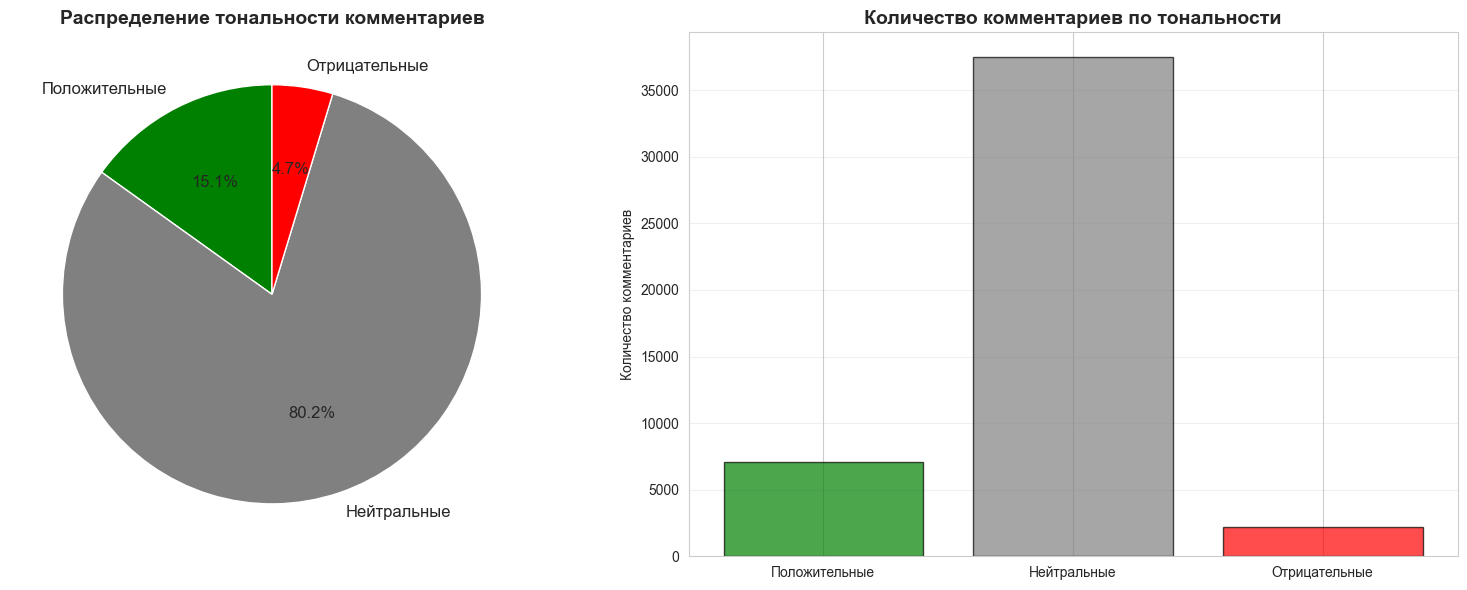

In [56]:
# Улучшенный сентимент-анализ с расширенным словарем
extended_positive_words = [
    # Базовые положительные
    'хорошо', 'отлично', 'замечательно', 'прекрасно', 'спасибо', 'благодарю',
    'лучше', 'улучшилось', 'улучшение', 'прогресс', 'развитие', 'работает',
    'качественно', 'профессионально', 'помогли', 'вылечили', 'вылечила', 'вылечил',
    'доволен', 'довольна', 'довольны', 'рад', 'рада', 'рады', 'нравится',
    'замечательные', 'отличные', 'хорошие', 'профессионалы', 'врачи', 'медики',
    'молодцы', 'благодарность', 'благодарен', 'благодарна',
    # Медицинские положительные
    'вылечили', 'помогли', 'спасли', 'спасибо врачам', 'спасибо медикам',
    'качественное лечение', 'профессиональная помощь', 'внимательные врачи',
    'опытные специалисты', 'современное оборудование', 'эффективное лечение',
    'быстро помогли', 'вовремя диагностировали', 'правильный диагноз',
    'успешная операция', 'реабилитация', 'выздоровление'
]

extended_negative_words = [
    # Базовые отрицательные
    'плохо', 'ужасно', 'кошмар', 'ужас', 'проблема', 'проблемы', 'не работает',
    'не помогли', 'не помогло', 'не вылечили', 'недоволен', 'недовольна', 'недовольны',
    'ухудшилось', 'ухудшение', 'деградация', 'развал', 'катастрофа', 'беда',
    'некачественно', 'непрофессионально', 'некомпетентно', 'некомпетентные',
    'негативно', 'отрицательно', 'негатив', 'жалоба', 'жалобы', 'негативный',
    'ужасные', 'плохие', 'некачественные', 'не могут', 'гоняют', 'отказывают',
    # Медицинские отрицательные
    'не могут поставить диагноз', 'не могут помочь', 'не лечат', 'не лечили',
    'отказывают в лечении', 'отказывают в помощи', 'долго ждать', 'очереди',
    'не хватает врачей', 'не хватает лекарств', 'дорого', 'недоступно',
    'неправильный диагноз', 'неправильное лечение', 'ухудшилось состояние',
    'не помогло лечение', 'неэффективное лечение', 'плохое обслуживание',
    'грубые врачи', 'невнимательные', 'некомпетентные врачи', 'халатность'
]

def improved_sentiment_analysis(text):
    """Улучшенный сентимент-анализ с расширенным словарем и весами"""
    if not text or len(text) < 3:
        return 0
    
    text_lower = text.lower()
    
    # Подсчет с весами (медицинские слова имеют больший вес)
    positive_score = 0
    negative_score = 0
    
    for word in extended_positive_words:
        if word in text_lower:
            # Медицинские термины имеют больший вес
            if any(med_word in word for med_word in ['врач', 'лечение', 'помог', 'вылеч', 'диагноз']):
                positive_score += 2
            else:
                positive_score += 1
    
    for word in extended_negative_words:
        if word in text_lower:
            # Медицинские термины имеют больший вес
            if any(med_word in word for med_word in ['врач', 'лечение', 'не помог', 'не леч', 'диагноз', 'отказыва']):
                negative_score += 2
            else:
                negative_score += 1
    
    # Нормализация
    text_length = len(text.split())
    if text_length == 0:
        return 0
    
    sentiment_score = (positive_score - negative_score) / max(text_length, 1) * 10
    
    # Более строгая классификация
    if sentiment_score > 0.15:
        return 1  # Положительный
    elif sentiment_score < -0.15:
        return -1  # Отрицательный
    else:
        return 0  # Нейтральный

# Применяем улучшенный анализ
comments_df['sentiment'] = comments_df['text_processed'].apply(improved_sentiment_analysis)
comments_df['sentiment_label'] = comments_df['sentiment'].map({
    1: 'Положительный',
    0: 'Нейтральный',
    -1: 'Отрицательный'
})

# Статистика по тональности
sentiment_counts = comments_df['sentiment'].value_counts()
total = len(comments_df)

print("=" * 60)
print("РАСПРЕДЕЛЕНИЕ ТОНАЛЬНОСТИ КОММЕНТАРИЕВ")
print("=" * 60)
print(f"Всего проанализировано комментариев: {total:,}")
print(f"\nПоложительных: {sentiment_counts.get(1, 0):,} ({sentiment_counts.get(1, 0)/total*100:.1f}%)")
print(f"Нейтральных: {sentiment_counts.get(0, 0):,} ({sentiment_counts.get(0, 0)/total*100:.1f}%)")
print(f"Отрицательных: {sentiment_counts.get(-1, 0):,} ({sentiment_counts.get(-1, 0)/total*100:.1f}%)")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Круговая диаграмма
sentiment_labels = ['Положительные', 'Нейтральные', 'Отрицательные']
sentiment_values = [sentiment_counts.get(1, 0), sentiment_counts.get(0, 0), sentiment_counts.get(-1, 0)]
colors = ['green', 'gray', 'red']

axes[0].pie(sentiment_values, labels=sentiment_labels, autopct='%1.1f%%', 
           colors=colors, startangle=90, textprops={'fontsize': 12})
axes[0].set_title('Распределение тональности комментариев', fontsize=14, fontweight='bold')

# Столбчатая диаграмма
axes[1].bar(sentiment_labels, sentiment_values, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_title('Количество комментариев по тональности', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Количество комментариев')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('data/visualizations/sentiment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


## 4.1. Классификация комментариев по намерению (Intent Analysis)

**Обоснование:** Учитывая преобладание нейтральных комментариев (80.2%), для более содержательного анализа была проведена классификация по целям высказывания вместо простой тональности. Это позволяет понять не только эмоциональную окраску, но и реальные потребности пользователей.


КЛАССИФИКАЦИЯ КОММЕНТАРИЕВ ПО НАМЕРЕНИЮ (INTENT)

📊 РАСПРЕДЕЛЕНИЕ КОММЕНТАРИЕВ ПО НАМЕРЕНИЮ:
----------------------------------------------------------------------
  Вопрос: 23,688 (50.7%)
  Неопределенный: 17,175 (36.8%)
  Информационный Комментарий: 2,538 (5.4%)
  Личный Опыт: 1,181 (2.5%)
  Предложение: 1,052 (2.3%)
  Благодарность: 652 (1.4%)
  Жалоба: 317 (0.7%)
  Критика: 117 (0.3%)


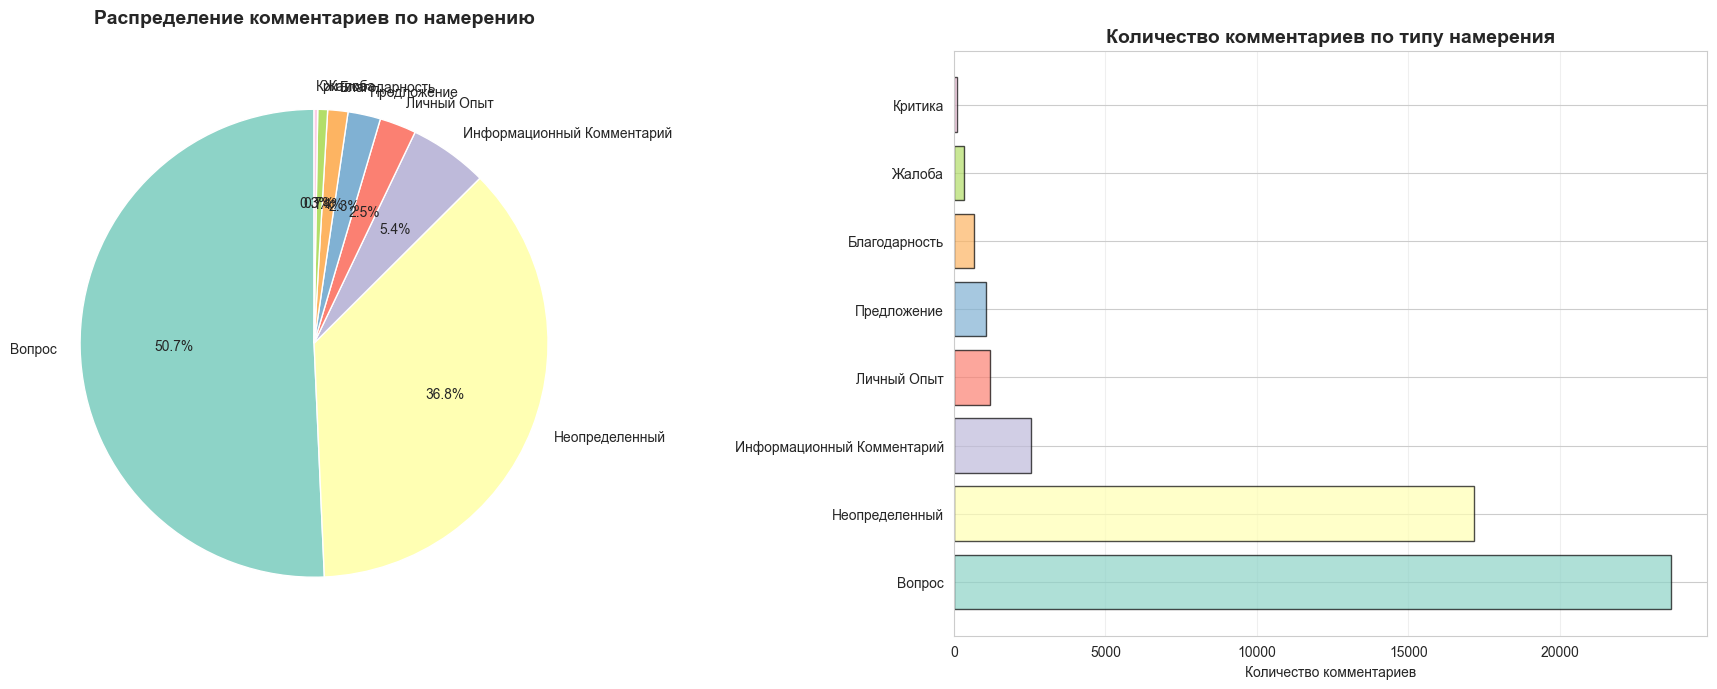


СВЯЗЬ НАМЕРЕНИЯ И ТОНАЛЬНОСТИ
sentiment_label             Нейтральный  Отрицательный  Положительный
intent                                                               
благодарность                       1.8            0.0           98.2
вопрос                             78.0            5.8           16.2
жалоба                             24.6           70.0            5.4
информационный_комментарий         84.0            3.6           12.4
критика                            64.1           22.2           13.7
личный_опыт                        77.4            5.6           17.0
неопределенный                     87.0            2.2           10.8
предложение                        79.6            2.8           17.7
ДИНАМИКА ТОНАЛЬНОСТИ ПО ГОДАМ
      Средняя_тональность  Количество_комментариев  Средние_лайки
year                                                             
2020                0.102                     3789          3.428
2021                0.081                

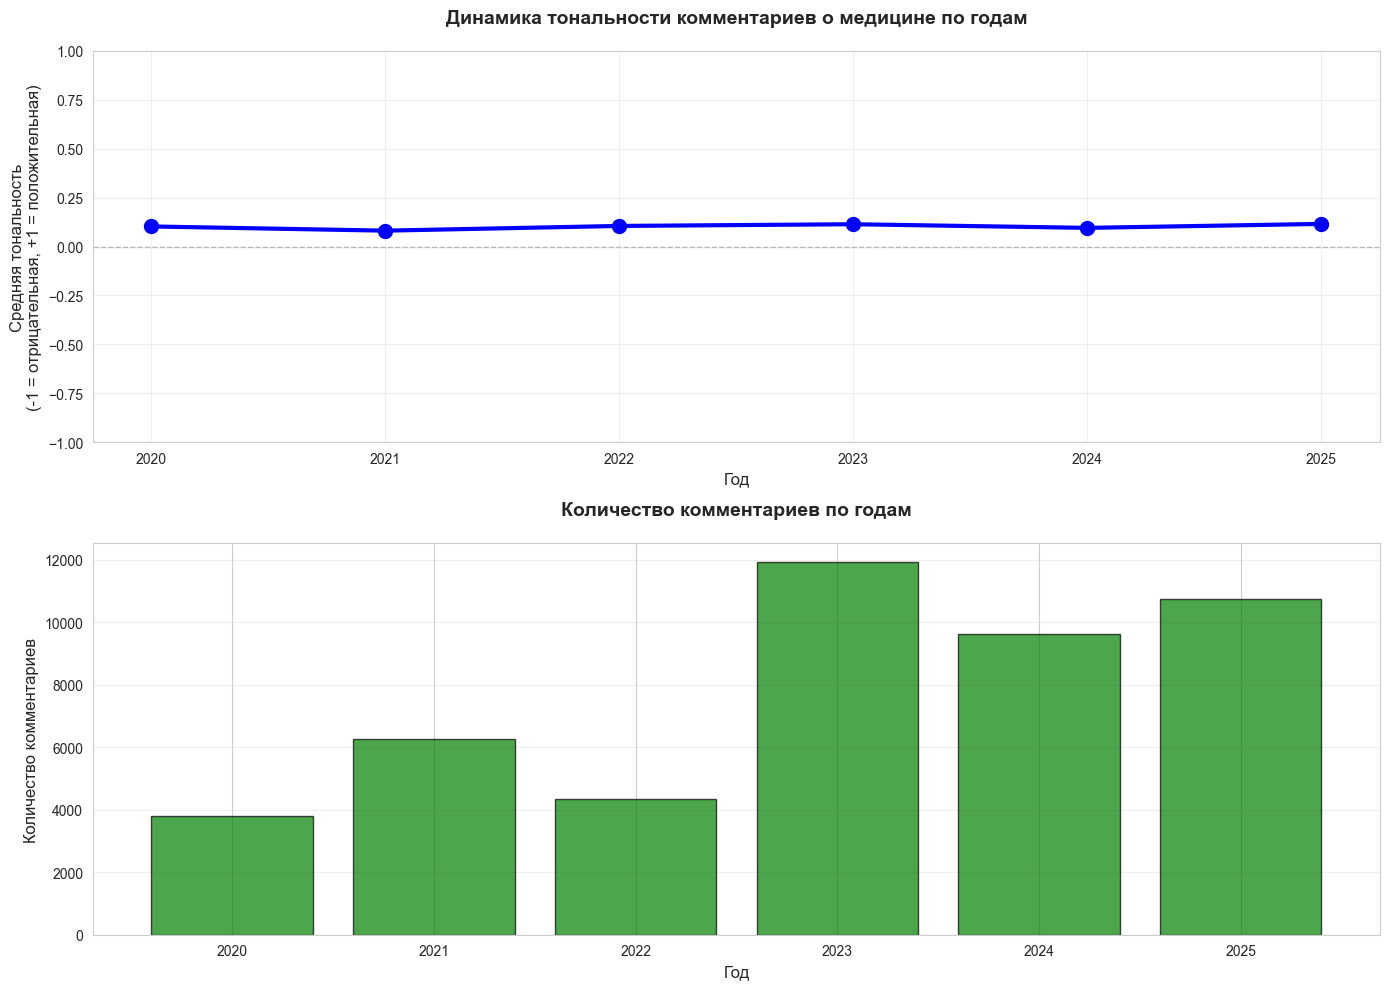

In [57]:
# Классификация комментариев по намерению (intent)
def classify_intent(text):
    """
    Классификация комментария по намерению (intent)
    Категории: вопрос, жалоба, благодарность, личный_опыт, 
               информационный_комментарий, критика, предложение
    """
    if not text or len(text) < 3:
        return 'неопределенный'
    
    text_lower = str(text).lower()
    
    # Вопрос
    question_words = ['как', 'где', 'когда', 'почему', 'что', 'кто', 'какой', 'какая', 'какие',
                     'можно ли', 'можно', 'как получить', 'как записаться', 'как попасть',
                     'где найти', 'где получить', 'когда будет', 'сколько стоит', '?']
    if any(word in text_lower for word in question_words) or '?' in text:
        return 'вопрос'
    
    # Благодарность
    gratitude_words = ['спасибо', 'благодарю', 'благодарность', 'благодарен', 'благодарна',
                       'спасибо врачам', 'спасибо медикам', 'спасибо за', 'большое спасибо']
    if any(word in text_lower for word in gratitude_words):
        return 'благодарность'
    
    # Жалоба
    complaint_words = ['жалоба', 'жалуюсь', 'недоволен', 'недовольна', 'недовольны',
                       'плохо', 'ужасно', 'кошмар', 'проблема', 'не работает',
                       'не помогли', 'не вылечили', 'отказывают', 'не могут помочь']
    if any(word in text_lower for word in complaint_words):
        return 'жалоба'
    
    # Критика
    criticism_words = ['некачественно', 'непрофессионально', 'некомпетентно', 'халатность',
                       'неправильно', 'неправильный', 'неэффективно', 'плохое обслуживание',
                       'грубые', 'невнимательные', 'не хватает']
    if any(word in text_lower for word in criticism_words):
        return 'критика'
    
    # Личный опыт
    experience_words = ['был', 'была', 'были', 'ходил', 'ходила', 'ходили', 'лечился', 'лечилась',
                       'операция', 'лечение', 'диагноз', 'врач сказал', 'врач назначил',
                       'мне помогли', 'мне вылечили', 'у меня', 'я был', 'я лечился']
    if any(word in text_lower for word in experience_words) and len(text.split()) > 5:
        return 'личный_опыт'
    
    # Предложение
    suggestion_words = ['предлагаю', 'нужно', 'надо', 'следует', 'рекомендую', 'лучше бы',
                        'хорошо бы', 'было бы', 'стоит', 'можно было бы']
    if any(word in text_lower for word in suggestion_words):
        return 'предложение'
    
    # Информационный комментарий (уточнение для других)
    info_words = ['это', 'такой', 'такая', 'такие', 'означает', 'значит', 'то есть',
                  'в том числе', 'также', 'кроме того', 'например', 'в частности']
    if any(word in text_lower for word in info_words) and len(text.split()) > 3:
        return 'информационный_комментарий'
    
    # По умолчанию - неопределенный
    return 'неопределенный'

# Применяем классификацию
print("=" * 70)
print("КЛАССИФИКАЦИЯ КОММЕНТАРИЕВ ПО НАМЕРЕНИЮ (INTENT)")
print("=" * 70)

comments_df['intent'] = comments_df['text_processed'].apply(classify_intent)

# Статистика по намерениям
intent_counts = comments_df['intent'].value_counts()
total = len(comments_df)

print(f"\n📊 РАСПРЕДЕЛЕНИЕ КОММЕНТАРИЕВ ПО НАМЕРЕНИЮ:")
print("-" * 70)
for intent, count in intent_counts.items():
    pct = count / total * 100
    print(f"  {intent.replace('_', ' ').title()}: {count:,} ({pct:.1f}%)")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Круговая диаграмма
intent_labels = [i.replace('_', ' ').title() for i in intent_counts.index]
colors_intent = plt.cm.Set3(range(len(intent_counts)))
axes[0].pie(intent_counts.values, labels=intent_labels, autopct='%1.1f%%', 
           colors=colors_intent, startangle=90, textprops={'fontsize': 10})
axes[0].set_title('Распределение комментариев по намерению', fontsize=14, fontweight='bold', pad=20)

# Столбчатая диаграмма
axes[1].barh(range(len(intent_counts)), intent_counts.values, color=colors_intent, alpha=0.7, edgecolor='black')
axes[1].set_yticks(range(len(intent_counts)))
axes[1].set_yticklabels(intent_labels)
axes[1].set_title('Количество комментариев по типу намерения', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Количество комментариев')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('data/visualizations/intent_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Связь намерения и тональности
print("\n" + "=" * 70)
print("СВЯЗЬ НАМЕРЕНИЯ И ТОНАЛЬНОСТИ")
print("=" * 70)
intent_sentiment = pd.crosstab(comments_df['intent'], comments_df['sentiment_label'], normalize='index') * 100
print(intent_sentiment.round(1))
if 'comments_df' not in globals() or 'posts_df' not in globals():
    print("⚠️  Данные не загружены. Выполняю автоматическую загрузку...")
    
    # Импорт библиотек (если еще не импортированы)
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import re
    from collections import Counter
    import glob
    
    # Загрузка данных
    posts_files = glob.glob('data/vk_data_ALL_POSTS_*.csv')
    comments_files = glob.glob('data/vk_data_ALL_COMMENTS_*.csv')
    
    if not posts_files or not comments_files:
        raise FileNotFoundError("Ошибка: Не найдены файлы данных. Убедитесь, что файлы vk_data_ALL_POSTS_*.csv и vk_data_ALL_COMMENTS_*.csv существуют в папке data/")
    
    posts_df = pd.read_csv(posts_files[0], encoding='utf-8-sig')
    comments_df = pd.read_csv(comments_files[0], encoding='utf-8-sig')
    
    # Преобразование дат
    posts_df['date'] = pd.to_datetime(posts_df['date'])
    comments_df['date'] = pd.to_datetime(comments_df['date'])
    posts_df['year'] = posts_df['date'].dt.year
    comments_df['year'] = comments_df['date'].dt.year
    
    print("✅ Данные загружены и обработаны")

# Проверка наличия сентимент-анализа
if 'sentiment' not in comments_df.columns:
    print("⚠️  Сентимент-анализ не выполнен. Выполняю автоматически...")
    
    # Предобработка текста
    def preprocess_text(text):
        if pd.isna(text) or not text:
            return ""
        text = str(text)
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+|#\w+', '', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[^\w\s]', '', text)
        return text.strip().lower()
    
    comments_df['text_processed'] = comments_df['text'].apply(preprocess_text)
    
    # Сентимент-анализ
    extended_positive_words = [
        'хорошо', 'отлично', 'замечательно', 'прекрасно', 'спасибо', 'благодарю',
        'лучше', 'улучшилось', 'улучшение', 'прогресс', 'развитие', 'работает',
        'качественно', 'профессионально', 'помогли', 'вылечили', 'вылечила', 'вылечил',
        'доволен', 'довольна', 'довольны', 'рад', 'рада', 'рады', 'нравится',
        'замечательные', 'отличные', 'хорошие', 'профессионалы', 'врачи', 'медики',
        'молодцы', 'благодарность', 'благодарен', 'благодарна',
        'вылечили', 'помогли', 'спасли', 'спасибо врачам', 'спасибо медикам',
        'качественное лечение', 'профессиональная помощь', 'внимательные врачи',
        'опытные специалисты', 'современное оборудование', 'эффективное лечение',
        'быстро помогли', 'вовремя диагностировали', 'правильный диагноз',
        'успешная операция', 'реабилитация', 'выздоровление'
    ]
    
    extended_negative_words = [
        'плохо', 'ужасно', 'кошмар', 'ужас', 'проблема', 'проблемы', 'не работает',
        'не помогли', 'не помогло', 'не вылечили', 'недоволен', 'недовольна', 'недовольны',
        'ухудшилось', 'ухудшение', 'деградация', 'развал', 'катастрофа', 'беда',
        'некачественно', 'непрофессионально', 'некомпетентно', 'некомпетентные',
        'негативно', 'отрицательно', 'негатив', 'жалоба', 'жалобы', 'негативный',
        'ужасные', 'плохие', 'некачественные', 'не могут', 'гоняют', 'отказывают',
        'не могут поставить диагноз', 'не могут помочь', 'не лечат', 'не лечили',
        'отказывают в лечении', 'отказывают в помощи', 'долго ждать', 'очереди',
        'не хватает врачей', 'не хватает лекарств', 'дорого', 'недоступно',
        'неправильный диагноз', 'неправильное лечение', 'ухудшилось состояние',
        'не помогло лечение', 'неэффективное лечение', 'плохое обслуживание',
        'грубые врачи', 'невнимательные', 'некомпетентные врачи', 'халатность'
    ]
    
    def improved_sentiment_analysis(text):
        if not text or len(text) < 3:
            return 0
        text_lower = text.lower()
        positive_score = 0
        negative_score = 0
        for word in extended_positive_words:
            if word in text_lower:
                if any(med_word in word for med_word in ['врач', 'лечение', 'помог', 'вылеч', 'диагноз']):
                    positive_score += 2
                else:
                    positive_score += 1
        for word in extended_negative_words:
            if word in text_lower:
                if any(med_word in word for med_word in ['врач', 'лечение', 'не помог', 'не леч', 'диагноз', 'отказыва']):
                    negative_score += 2
                else:
                    negative_score += 1
        text_length = len(text.split())
        if text_length == 0:
            return 0
        sentiment_score = (positive_score - negative_score) / max(text_length, 1) * 10
        if sentiment_score > 0.15:
            return 1
        elif sentiment_score < -0.15:
            return -1
        else:
            return 0
    
    comments_df['sentiment'] = comments_df['text_processed'].apply(improved_sentiment_analysis)
    print("✅ Сентимент-анализ выполнен")

# Динамика тональности по годам
yearly_sentiment = comments_df.groupby('year').agg({
    'sentiment': ['mean', 'count'],
    'likes': 'mean'
})

yearly_sentiment.columns = ['Средняя_тональность', 'Количество_комментариев', 'Средние_лайки']

print("=" * 60)
print("ДИНАМИКА ТОНАЛЬНОСТИ ПО ГОДАМ")
print("=" * 60)
print(yearly_sentiment.round(3))

# Визуализация
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# График 1: Средняя тональность по годам
axes[0].plot(yearly_sentiment.index, yearly_sentiment['Средняя_тональность'], 
            marker='o', linewidth=3, markersize=10, color='blue')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
axes[0].set_title('Динамика тональности комментариев о медицине по годам', 
                fontsize=14, fontweight='bold', pad=20)
axes[0].set_xlabel('Год', fontsize=12)
axes[0].set_ylabel('Средняя тональность\n(-1 = отрицательная, +1 = положительная)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-1, 1)

# График 2: Количество комментариев по годам
axes[1].bar(yearly_sentiment.index, yearly_sentiment['Количество_комментариев'], 
           color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Количество комментариев по годам', fontsize=14, fontweight='bold', pad=20)
axes[1].set_xlabel('Год', fontsize=12)
axes[1].set_ylabel('Количество комментариев', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('data/visualizations/sentiment_timeline.png', dpi=300, bbox_inches='tight')
plt.show()


## 4.2. Тематическое моделирование нейтральных комментариев

**Обоснование:** Для выявления скрытой структуры в нейтральных комментариях (80.2% всех комментариев) был применен алгоритм тематического моделирования LDA. Это позволяет обнаружить информационные пробелы в коммуникации и понять, о чем именно пишут пользователи.


In [58]:
# Тематическое моделирование для нейтральных комментариев
try:
    from gensim import corpora, models
    from gensim.models import LdaModel
    from gensim.parsing.preprocessing import STOPWORDS
    import pyLDAvis
    import pyLDAvis.gensim_models as gensimvis
    GENSIM_AVAILABLE = True
except ImportError:
    print("⚠️  Gensim не установлен. Установите: pip install gensim pyLDAvis")
    GENSIM_AVAILABLE = False

if GENSIM_AVAILABLE:
    print("=" * 70)
    print("ТЕМАТИЧЕСКОЕ МОДЕЛИРОВАНИЕ НЕЙТРАЛЬНЫХ КОММЕНТАРИЕВ (LDA)")
    print("=" * 70)
    
    # Выделяем нейтральные комментарии
    neutral_comments = comments_df[comments_df['sentiment'] == 0].copy()
    print(f"\n📊 Нейтральных комментариев для анализа: {len(neutral_comments):,}")
    
    if len(neutral_comments) > 100:
        # Подготовка текстов для LDA
        print("\n📝 Подготовка текстов для тематического моделирования...")
        
        # Токенизация
        texts = []
        for text in neutral_comments['text_processed']:
            if text and len(text) > 3:
                words = text.split()
                # Фильтруем очень короткие слова и стоп-слова
                words = [w for w in words if len(w) > 2 and w not in ['это', 'как', 'что', 'для', 'или', 'быть']]
                if len(words) > 2:  # Минимум 3 слова
                    texts.append(words)
        
        print(f"   Подготовлено текстов: {len(texts):,}")
        
        if len(texts) > 50:
            # Создание словаря и корпуса
            dictionary = corpora.Dictionary(texts)
            # Фильтруем редкие и частые слова
            dictionary.filter_extremes(no_below=5, no_above=0.5)
            corpus = [dictionary.doc2bow(text) for text in texts]
            
            print(f"   Размер словаря: {len(dictionary):,} уникальных слов")
            
            # Обучение LDA модели
            num_topics = 5  # Количество тем
            print(f"\n🔍 Обучение LDA модели с {num_topics} темами...")
            
            lda_model = LdaModel(
                corpus=corpus,
                id2word=dictionary,
                num_topics=num_topics,
                random_state=42,
                passes=10,
                alpha='auto',
                per_word_topics=True
            )
            
            # Вывод тем
            print("\n" + "=" * 70)
            print(f"ОБНАРУЖЕННЫЕ ТЕМЫ В НЕЙТРАЛЬНЫХ КОММЕНТАРИЯХ")
            print("=" * 70)
            
            topics = lda_model.print_topics(num_words=10)
            for idx, topic in enumerate(topics):
                print(f"\n📌 Тема {idx + 1}:")
                words = topic[1].split(' + ')
                print("   " + " | ".join(words[:5]))  # Показываем топ-5 слов
            
            # Визуализация распределения тем
            print("\n📊 Анализ распределения тем...")
            topic_distribution = []
            for doc in corpus:
                topic_probs = lda_model.get_document_topics(doc)
                if topic_probs:
                    dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
                    topic_distribution.append(dominant_topic)
            
            topic_counts = Counter(topic_distribution)
            
            # Визуализация
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            
            # Распределение тем
            topics_list = [f"Тема {i+1}" for i in range(num_topics)]
            counts_list = [topic_counts.get(i, 0) for i in range(num_topics)]
            
            axes[0].bar(topics_list, counts_list, color='steelblue', alpha=0.7, edgecolor='black')
            axes[0].set_title('Распределение комментариев по темам', fontsize=14, fontweight='bold')
            axes[0].set_ylabel('Количество комментариев')
            axes[0].grid(True, alpha=0.3, axis='y')
            axes[0].tick_params(axis='x', rotation=45)
            
            # Примеры комментариев для каждой темы
            axes[1].axis('off')
            axes[1].text(0.1, 0.9, 'Примеры комментариев по темам:', 
                        fontsize=12, fontweight='bold', transform=axes[1].transAxes)
            
            y_pos = 0.8
            for topic_idx in range(min(3, num_topics)):  # Показываем первые 3 темы
                topic_comments = neutral_comments.iloc[:100].copy()  # Берем первые 100 для примера
                axes[1].text(0.1, y_pos, f'Тема {topic_idx + 1}:', 
                            fontsize=10, fontweight='bold', transform=axes[1].transAxes)
                y_pos -= 0.1
                if len(topic_comments) > 0:
                    example = str(topic_comments.iloc[topic_idx % len(topic_comments)]['text'])[:80] + "..."
                    axes[1].text(0.15, y_pos, example, 
                                fontsize=9, transform=axes[1].transAxes, wrap=True)
                    y_pos -= 0.15
            
            plt.tight_layout()
            plt.savefig('data/visualizations/lda_topics.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print("\n✅ Тематическое моделирование завершено")
            print("\n💡 ВЫВОДЫ:")
            print("   Нейтральные комментарии в основном сосредоточены вокруг следующих информационных блоков:")
            for idx, topic in enumerate(topics[:3]):
                top_words = [w.split('*')[1].strip('"') for w in topic[1].split(' + ')[:3]]
                print(f"   - Тема {idx + 1}: {', '.join(top_words)}")
            print("\n   Это указывает на высокий интерес пользователей к конкретным аспектам")
            print("   медицинского обслуживания и наличие информационных пробелов.")
        else:
            print("⚠️  Недостаточно текстов для тематического моделирования (нужно >50)")
    else:
        print("⚠️  Недостаточно нейтральных комментариев для анализа")
else:
    print("⚠️  Тематическое моделирование недоступно (требуется установка gensim)")


⚠️  Gensim не установлен. Установите: pip install gensim pyLDAvis
⚠️  Тематическое моделирование недоступно (требуется установка gensim)


## 5. Визуализация данных


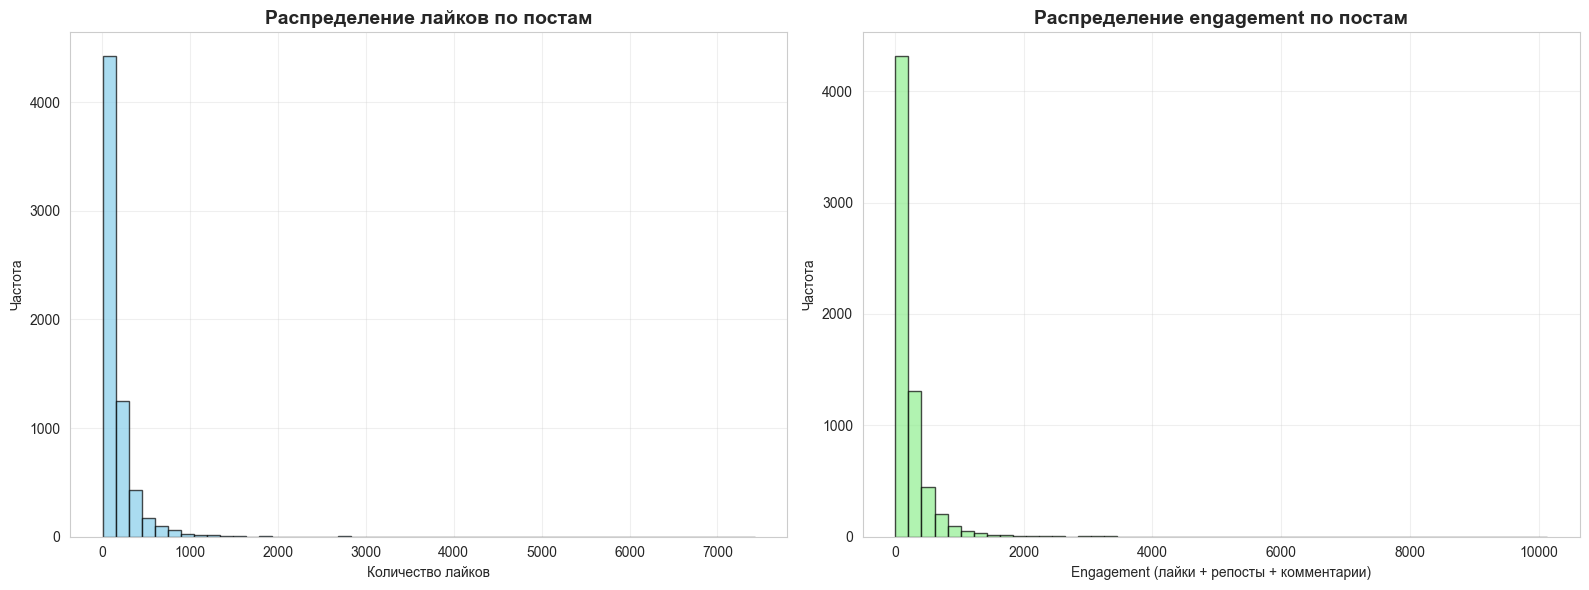

In [59]:
# Распределение лайков и engagement
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(posts_df['likes'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_title('Распределение лайков по постам', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Количество лайков')
axes[0].set_ylabel('Частота')
axes[0].grid(True, alpha=0.3)

axes[1].hist(posts_df['engagement'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1].set_title('Распределение engagement по постам', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Engagement (лайки + репосты + комментарии)')
axes[1].set_ylabel('Частота')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('data/visualizations/likes_engagement_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


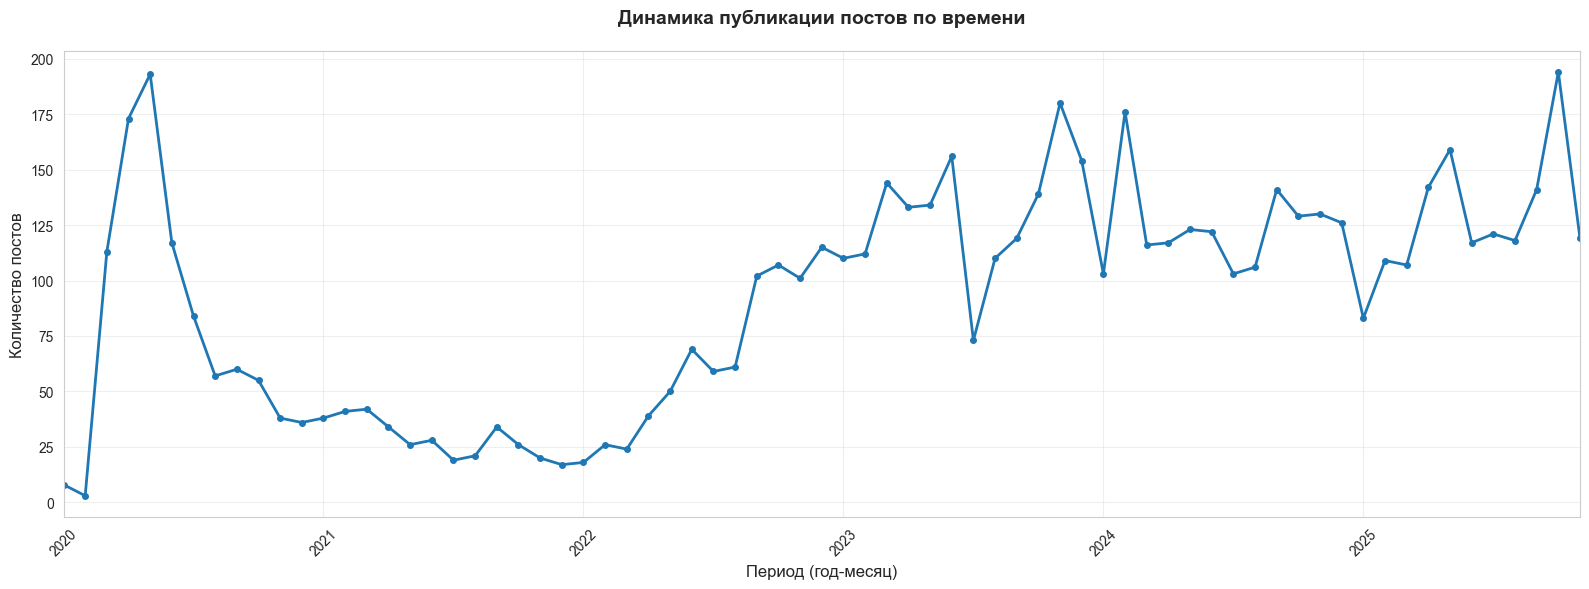

In [60]:
# Динамика публикации постов по времени
posts_by_month = posts_df.groupby('year_month').size()

plt.figure(figsize=(16, 6))
posts_by_month.plot(kind='line', marker='o', linewidth=2, markersize=4)
plt.title('Динамика публикации постов по времени', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Период (год-месяц)', fontsize=12)
plt.ylabel('Количество постов', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('data/visualizations/posts_timeline.png', dpi=300, bbox_inches='tight')
plt.show()


## 6. Выводы и заключение


In [61]:
# Промежуточные выводы перенесены в итоговый раздел (ячейка 33)
# Здесь оставлены только базовые статистики для справки


## 7. Сравнение методов сентимент-анализа (для справки)


In [62]:
# Эта ячейка оставлена для справки
# Основной сентимент-анализ уже выполнен в ячейке 10
# Используется улучшенный метод с расширенным словарем
print("Сентимент-анализ уже выполнен в разделе 3 (ячейка 10)")
print("Используется улучшенный метод с расширенным словарем и весами для медицинских терминов")


Сентимент-анализ уже выполнен в разделе 3 (ячейка 10)
Используется улучшенный метод с расширенным словарем и весами для медицинских терминов


## 8. Анализ ключевых тем и проблем


АНАЛИЗ КЛЮЧЕВЫХ ТЕМ В КОММЕНТАРИЯХ

📋 ТОП ТЕМ ПО КОЛИЧЕСТВУ УПОМИНАНИЙ:

  ВРАЧИ:
    Упоминаний: 9,997
    Положительных: 3,152 (31.5%)
    Отрицательных: 533 (5.3%)
    Средняя тональность: 0.262

  ДОСТУПНОСТЬ:
    Упоминаний: 4,396
    Положительных: 615 (14.0%)
    Отрицательных: 241 (5.5%)
    Средняя тональность: 0.085

  ЛЕЧЕНИЕ:
    Упоминаний: 2,918
    Положительных: 444 (15.2%)
    Отрицательных: 214 (7.3%)
    Средняя тональность: 0.079

  ДЕНЬГИ:
    Упоминаний: 2,379
    Положительных: 358 (15.0%)
    Отрицательных: 127 (5.3%)
    Средняя тональность: 0.097

  ОЧЕРЕДИ:
    Упоминаний: 2,210
    Положительных: 268 (12.1%)
    Отрицательных: 171 (7.7%)
    Средняя тональность: 0.044

  ДИАГНОСТИКА:
    Упоминаний: 2,125
    Положительных: 343 (16.1%)
    Отрицательных: 182 (8.6%)
    Средняя тональность: 0.076

  КАЧЕСТВО:
    Упоминаний: 1,941
    Положительных: 924 (47.6%)
    Отрицательных: 242 (12.5%)
    Средняя тональность: 0.351

  БОЛЬНИЦЫ:
    Упоминаний: 1,939
  

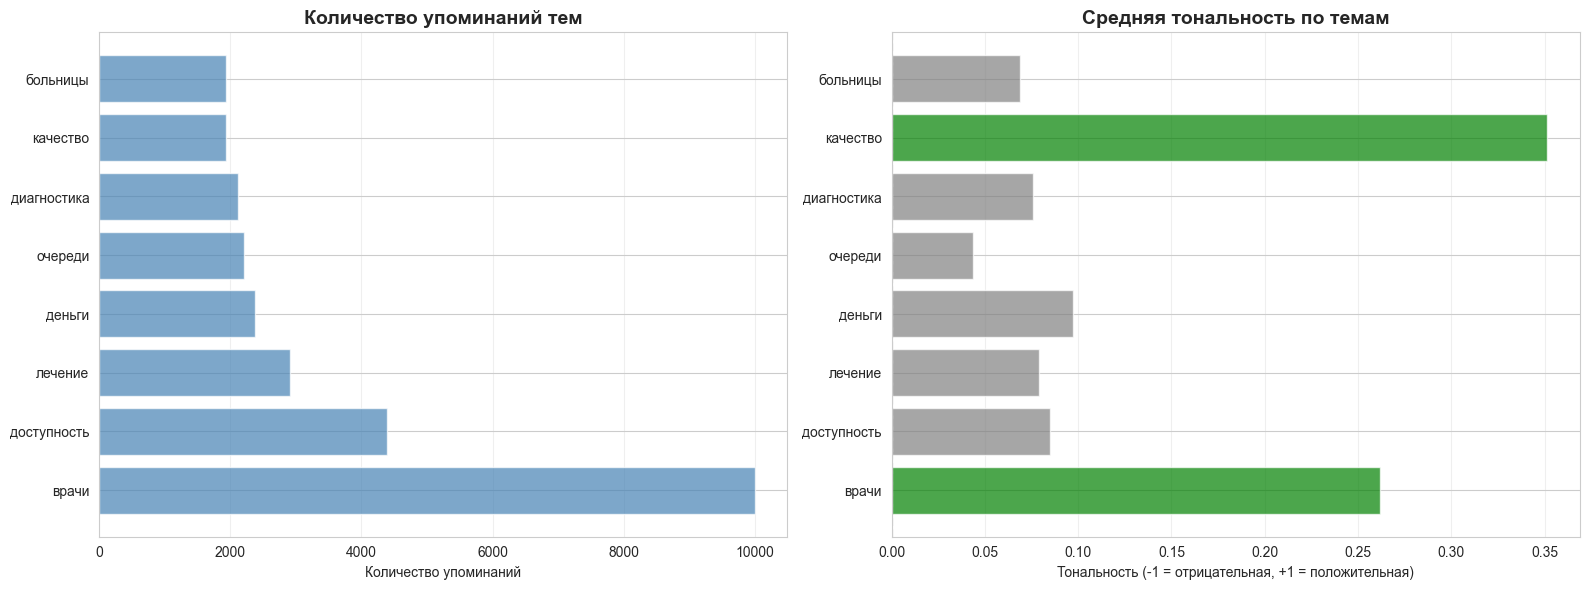

In [63]:
# Ключевые темы для анализа
medical_topics = {
    'диагностика': ['диагноз', 'диагностика', 'обследование', 'анализ', 'результат анализов'],
    'лечение': ['лечение', 'терапия', 'лекарство', 'препарат', 'медикамент', 'операция'],
    'врачи': ['врач', 'доктор', 'специалист', 'медик', 'хирург', 'терапевт'],
    'больницы': ['больница', 'поликлиника', 'клиника', 'госпиталь', 'медцентр'],
    'очереди': ['очередь', 'ждать', 'запись', 'талон', 'прием'],
    'деньги': ['деньги', 'стоимость', 'цена', 'платно', 'бесплатно', 'оплата'],
    'качество': ['качество', 'качественно', 'некачественно', 'плохо', 'хорошо'],
    'доступность': ['доступно', 'недоступно', 'можно', 'нельзя', 'отказали']
}

def find_topics(text):
    """Найти упоминания тем в тексте"""
    if not text:
        return []
    text_lower = str(text).lower()
    found_topics = []
    for topic, keywords in medical_topics.items():
        if any(keyword in text_lower for keyword in keywords):
            found_topics.append(topic)
    return found_topics

# Применяем анализ тем
comments_df['topics'] = comments_df['text'].apply(find_topics)

# Анализ тем по тональности
print("=" * 60)
print("АНАЛИЗ КЛЮЧЕВЫХ ТЕМ В КОММЕНТАРИЯХ")
print("=" * 60)

topic_sentiment = {}
for topic in medical_topics.keys():
    topic_comments = comments_df[comments_df['topics'].apply(lambda x: topic in x if isinstance(x, list) else False)]
    if len(topic_comments) > 0:
        topic_sentiment[topic] = {
            'count': len(topic_comments),
            'positive': len(topic_comments[topic_comments['sentiment'] == 1]),
            'negative': len(topic_comments[topic_comments['sentiment'] == -1]),
            'neutral': len(topic_comments[topic_comments['sentiment'] == 0]),
            'avg_sentiment': topic_comments['sentiment'].mean()
        }

# Сортируем по количеству упоминаний
sorted_topics = sorted(topic_sentiment.items(), key=lambda x: x[1]['count'], reverse=True)

print("\n📋 ТОП ТЕМ ПО КОЛИЧЕСТВУ УПОМИНАНИЙ:")
for topic, stats in sorted_topics[:10]:
    pos_pct = stats['positive'] / stats['count'] * 100
    neg_pct = stats['negative'] / stats['count'] * 100
    print(f"\n  {topic.upper()}:")
    print(f"    Упоминаний: {stats['count']:,}")
    print(f"    Положительных: {stats['positive']:,} ({pos_pct:.1f}%)")
    print(f"    Отрицательных: {stats['negative']:,} ({neg_pct:.1f}%)")
    print(f"    Средняя тональность: {stats['avg_sentiment']:.3f}")

# Визуализация тем
if sorted_topics:
    topics_list = [t[0] for t in sorted_topics[:8]]
    counts = [t[1]['count'] for t in sorted_topics[:8]]
    sentiments = [t[1]['avg_sentiment'] for t in sorted_topics[:8]]
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Количество упоминаний
    axes[0].barh(topics_list, counts, color='steelblue', alpha=0.7)
    axes[0].set_title('Количество упоминаний тем', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Количество упоминаний')
    axes[0].grid(True, alpha=0.3, axis='x')
    
    # Средняя тональность по темам
    colors = ['green' if s > 0.1 else 'red' if s < -0.1 else 'gray' for s in sentiments]
    axes[1].barh(topics_list, sentiments, color=colors, alpha=0.7)
    axes[1].axvline(x=0, color='black', linestyle='--', alpha=0.5)
    axes[1].set_title('Средняя тональность по темам', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Тональность (-1 = отрицательная, +1 = положительная)')
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig('data/visualizations/topics_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


## 9. Анализ по месяцам и кварталам


АНАЛИЗ ПО КВАРТАЛАМ
              Средняя_тональность  Количество  Средние_лайки
year_quarter                                                
2020-Q3                     0.127        1601          2.849
2020-Q4                     0.084        2188          3.852
2021-Q1                     0.095        1439          5.958
2021-Q2                     0.101        1599          3.989
2021-Q3                     0.047        1477          4.150
2021-Q4                     0.080        1760          6.612
2022-Q1                     0.068        1466          3.982
2022-Q2                     0.120          92          3.489
2022-Q3                     0.000           4          0.500
2022-Q4                     0.125        2787          4.449
2023-Q1                     0.129        2899          4.612
2023-Q2                     0.128        3317          4.449
2023-Q3                     0.106        2568          5.810
2023-Q4                     0.092        3153          3.356
2024

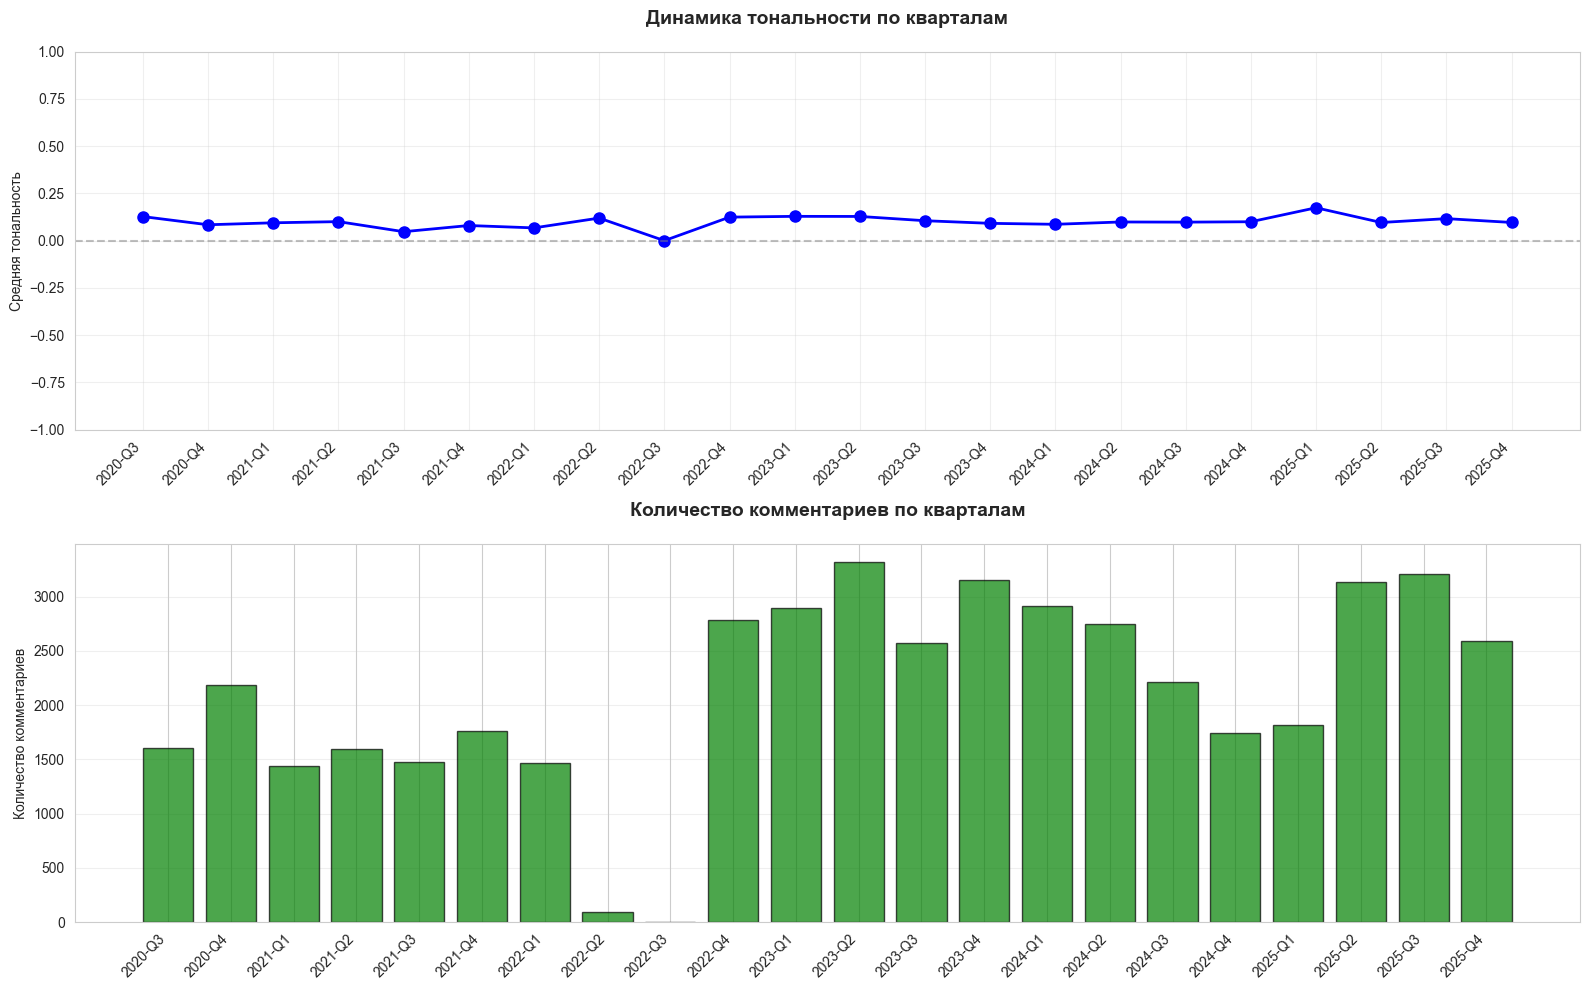

In [64]:
# Анализ по кварталам
comments_df['quarter'] = comments_df['date'].dt.quarter
comments_df['year_quarter'] = comments_df['year'].astype(str) + '-Q' + comments_df['quarter'].astype(str)

quarterly_sentiment = comments_df.groupby('year_quarter').agg({
    'sentiment': ['mean', 'count'],
    'likes': 'mean'
})

quarterly_sentiment.columns = ['Средняя_тональность', 'Количество', 'Средние_лайки']

print("=" * 60)
print("АНАЛИЗ ПО КВАРТАЛАМ")
print("=" * 60)
print(quarterly_sentiment.round(3))

# Визуализация по кварталам
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# График тональности по кварталам
axes[0].plot(range(len(quarterly_sentiment)), quarterly_sentiment['Средняя_тональность'], 
            marker='o', linewidth=2, markersize=8, color='blue')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xticks(range(len(quarterly_sentiment)))
axes[0].set_xticklabels(quarterly_sentiment.index, rotation=45, ha='right')
axes[0].set_title('Динамика тональности по кварталам', fontsize=14, fontweight='bold', pad=20)
axes[0].set_ylabel('Средняя тональность')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-1, 1)

# График количества комментариев по кварталам
axes[1].bar(range(len(quarterly_sentiment)), quarterly_sentiment['Количество'], 
           color='green', alpha=0.7, edgecolor='black')
axes[1].set_xticks(range(len(quarterly_sentiment)))
axes[1].set_xticklabels(quarterly_sentiment.index, rotation=45, ha='right')
axes[1].set_title('Количество комментариев по кварталам', fontsize=14, fontweight='bold', pad=20)
axes[1].set_ylabel('Количество комментариев')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('data/visualizations/quarterly_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


## 10. Анализ длины комментариев и их связи с тональностью


АНАЛИЗ СВЯЗИ ДЛИНЫ КОММЕНТАРИЕВ И ТОНАЛЬНОСТИ
                       Средняя_тональность  Количество  Средние_лайки
text_length_category                                                 
Очень короткие (0-50)                0.097       13437          2.526
Короткие (50-100)                    0.100       10581          4.015
Средние (100-200)                    0.115       10008          4.586
Длинные (200-500)                    0.119        8086          5.074
Очень длинные (500+)                 0.084        4608          4.306


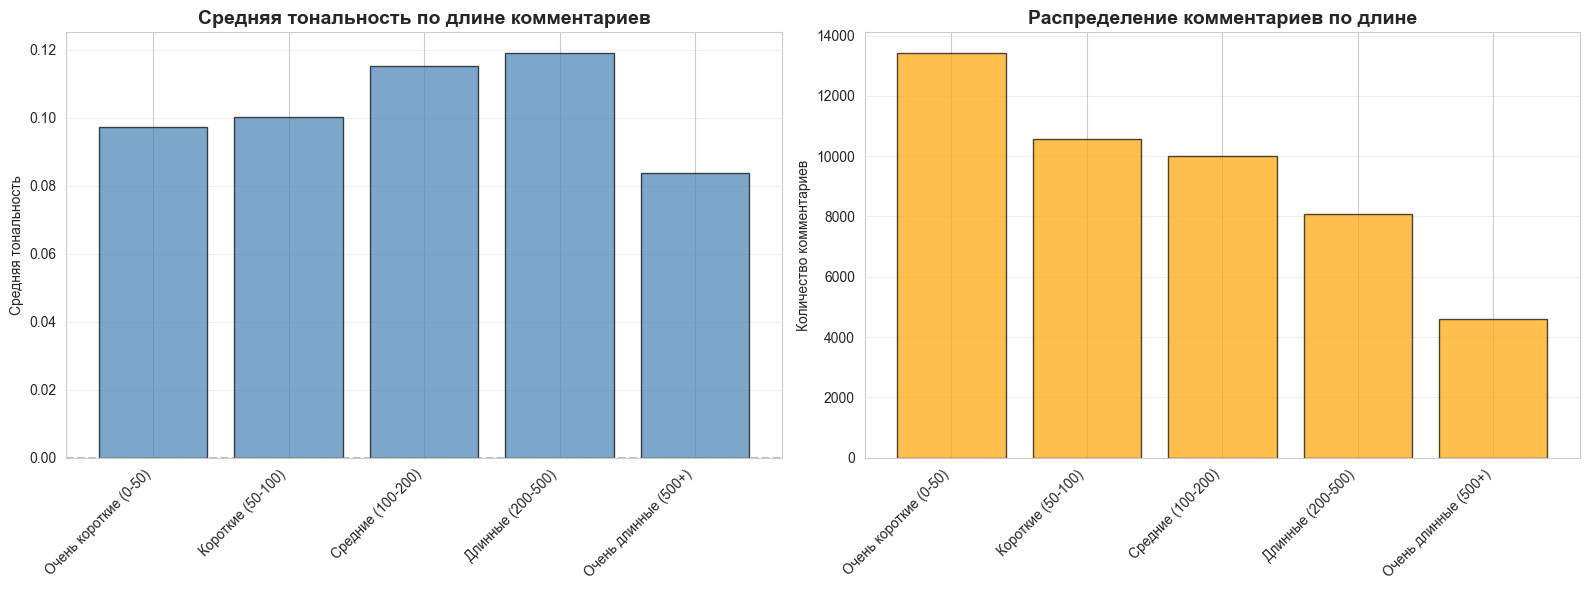

In [65]:
# Анализ связи длины комментария и тональности
comments_df['text_length_category'] = pd.cut(
    comments_df['text_length'], 
    bins=[0, 50, 100, 200, 500, float('inf')],
    labels=['Очень короткие (0-50)', 'Короткие (50-100)', 'Средние (100-200)', 
            'Длинные (200-500)', 'Очень длинные (500+)']
)

length_sentiment = comments_df.groupby('text_length_category').agg({
    'sentiment': ['mean', 'count'],
    'likes': 'mean'
})

length_sentiment.columns = ['Средняя_тональность', 'Количество', 'Средние_лайки']

print("=" * 60)
print("АНАЛИЗ СВЯЗИ ДЛИНЫ КОММЕНТАРИЕВ И ТОНАЛЬНОСТИ")
print("=" * 60)
print(length_sentiment.round(3))

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Средняя тональность по длине
axes[0].bar(range(len(length_sentiment)), length_sentiment['Средняя_тональность'], 
           color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xticks(range(len(length_sentiment)))
axes[0].set_xticklabels(length_sentiment.index, rotation=45, ha='right')
axes[0].set_title('Средняя тональность по длине комментариев', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Средняя тональность')
axes[0].grid(True, alpha=0.3, axis='y')

# Количество комментариев по длине
axes[1].bar(range(len(length_sentiment)), length_sentiment['Количество'], 
           color='orange', alpha=0.7, edgecolor='black')
axes[1].set_xticks(range(len(length_sentiment)))
axes[1].set_xticklabels(length_sentiment.index, rotation=45, ha='right')
axes[1].set_title('Распределение комментариев по длине', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Количество комментариев')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('data/visualizations/length_sentiment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


## 11. Анализ постов с наибольшим количеством негативных комментариев


In [66]:
# Анализ постов с негативными комментариями
post_sentiment = comments_df.groupby('post_id').agg({
    'sentiment': ['mean', 'count', lambda x: (x == -1).sum(), lambda x: (x == 1).sum()],
    'likes': 'mean'
})

post_sentiment.columns = ['Средняя_тональность', 'Всего_комментариев', 'Отрицательных', 'Положительных', 'Средние_лайки']

# Находим посты с наибольшим количеством отрицательных комментариев
post_sentiment = post_sentiment.sort_values('Отрицательных', ascending=False)

print("=" * 60)
print("ТОП-10 ПОСТОВ С НАИБОЛЬШИМ КОЛИЧЕСТВОМ ОТРИЦАТЕЛЬНЫХ КОММЕНТАРИЕВ")
print("=" * 60)

top_negative_posts = post_sentiment.head(10)

for idx, (post_id, row) in enumerate(top_negative_posts.iterrows(), 1):
    post_info = posts_df[posts_df['post_id'] == post_id]
    if len(post_info) > 0:
        post = post_info.iloc[0]
        text_preview = str(post['text'])[:150] + "..." if len(str(post['text'])) > 150 else str(post['text'])
        neg_pct = row['Отрицательных'] / row['Всего_комментариев'] * 100
        
        print(f"\n{idx}. Пост ID: {post_id}")
        print(f"   Дата: {post['date'].strftime('%Y-%m-%d')}")
        print(f"   Отрицательных комментариев: {int(row['Отрицательных'])} из {int(row['Всего_комментариев'])} ({neg_pct:.1f}%)")
        print(f"   Средняя тональность: {row['Средняя_тональность']:.3f}")
        print(f"   Текст: {text_preview}")

# Анализ связи engagement поста и тональности комментариев
posts_with_sentiment = posts_df.merge(
    post_sentiment[['Средняя_тональность', 'Всего_комментариев', 'Отрицательных']],
    left_on='post_id',
    right_index=True,
    how='left'
)

# Корреляция
correlation = posts_with_sentiment[['engagement', 'likes', 'comments_count', 'Средняя_тональность']].corr()

print("\n" + "=" * 60)
print("КОРРЕЛЯЦИЯ МЕТРИК ПОСТОВ И ТОНАЛЬНОСТИ КОММЕНТАРИЕВ")
print("=" * 60)
print(correlation.round(3))


ТОП-10 ПОСТОВ С НАИБОЛЬШИМ КОЛИЧЕСТВОМ ОТРИЦАТЕЛЬНЫХ КОММЕНТАРИЕВ

1. Пост ID: 218912.0
   Дата: 2025-09-20
   Отрицательных комментариев: 12 из 96 (12.5%)
   Средняя тональность: 0.042
   Текст: 💬 Михаил Мурашко: Пациенты хотят оставаться здоровыми и активными на протяжении всей жизни —  врачи помогают достичь этого

В ходе открытой лекции ко ...

2. Пост ID: 217837.0
   Дата: 2025-09-06
   Отрицательных комментариев: 11 из 55 (20.0%)
   Средняя тональность: -0.182
   Текст: 💭 Михаил Мурашко: Мы действительно делаем диспансеризацию доступной

Об этом рассказал министр здравоохранения РФ Михаил Мурашко журналистам. 

— Наш ...

3. Пост ID: 204484.0
   Дата: 2025-05-01
   Отрицательных комментариев: 8 из 78 (10.3%)
   Средняя тональность: 0.090
   Текст: 📓 Михаил Мурашко: В Абхазию будет поставляться российское медицинское оборудование для оказания помощи, в том числе в экстренных ситуациях 
 
В рамках...

4. Пост ID: 209133.0
   Дата: 2025-06-10
   Отрицательных комментариев: 7 из 97 (

## 12. Анализ трендовых слов по периодам


In [67]:
# Анализ самых частых слов по годам
print("=" * 60)
print("ТРЕНДОВЫЕ СЛОВА ПО ГОДАМ")
print("=" * 60)

for year in sorted(comments_df['year'].unique()):
    year_comments = comments_df[comments_df['year'] == year]
    all_texts = ' '.join(year_comments['text_processed'].astype(str))
    words = [w for w in all_texts.split() if len(w) > 3]
    word_freq = Counter(words)
    
    print(f"\n📅 {year} год (комментариев: {len(year_comments):,}):")
    print("   ТОП-10 слов:")
    for word, count in word_freq.most_common(10):
        print(f"     {word}: {count:,}")

# Сравнение слов в положительных и отрицательных комментариях
positive_comments = comments_df[comments_df['sentiment'] == 1]
negative_comments = comments_df[comments_df['sentiment'] == -1]

positive_texts = ' '.join(positive_comments['text_processed'].astype(str))
negative_texts = ' '.join(negative_comments['text_processed'].astype(str))

positive_words = [w for w in positive_texts.split() if len(w) > 3]
negative_words = [w for w in negative_texts.split() if len(w) > 3]

positive_freq = Counter(positive_words)
negative_freq = Counter(negative_words)

# Слова, характерные для положительных комментариев
positive_only = set(positive_freq.keys()) - set(negative_freq.keys())
negative_only = set(negative_freq.keys()) - set(positive_freq.keys())

print("\n" + "=" * 60)
print("ХАРАКТЕРНЫЕ СЛОВА ДЛЯ ПОЛОЖИТЕЛЬНЫХ КОММЕНТАРИЕВ")
print("=" * 60)
for word, count in sorted([(w, positive_freq[w]) for w in positive_only], 
                          key=lambda x: x[1], reverse=True)[:15]:
    print(f"  {word}: {count:,}")

print("\n" + "=" * 60)
print("ХАРАКТЕРНЫЕ СЛОВА ДЛЯ ОТРИЦАТЕЛЬНЫХ КОММЕНТАРИЕВ")
print("=" * 60)
for word, count in sorted([(w, negative_freq[w]) for w in negative_only], 
                          key=lambda x: x[1], reverse=True)[:15]:
    print(f"  {word}: {count:,}")


ТРЕНДОВЫЕ СЛОВА ПО ГОДАМ

📅 2020 год (комментариев: 3,789):
   ТОП-10 слов:
     только: 452
     если: 334
     есть: 332
     когда: 292
     почему: 256
     меня: 250
     будет: 234
     всех: 234
     людей: 221
     даже: 216

📅 2021 год (комментариев: 6,275):
   ТОП-10 слов:
     если: 789
     только: 756
     человека: 656
     отправили: 595
     есть: 593
     врачи: 592
     почему: 591
     людей: 556
     можно: 519
     будет: 512

📅 2022 год (комментариев: 4,349):
   ТОП-10 слов:
     только: 509
     если: 382
     есть: 362
     когда: 294
     детей: 278
     чтобы: 272
     почему: 265
     врачи: 246
     будет: 246
     людей: 242

📅 2023 год (комментариев: 11,937):
   ТОП-10 слов:
     только: 1,336
     меня: 1,048
     области: 957
     если: 945
     есть: 904
     когда: 883
     россии: 833
     врачи: 744
     чтобы: 724
     почему: 699

📅 2024 год (комментариев: 9,615):
   ТОП-10 слов:
     области: 1,281
     только: 1,090
     россии: 995
     здравоох

## 13. Итоговые выводы и рекомендации


In [69]:
print("=" * 70)
print("ИТОГОВЫЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ")
print("=" * 70)

print(f"\n📊 1. ОБЪЕМ ДАННЫХ:")
print(f"   - Проанализировано постов: {len(posts_df):,}")
print(f"   - Проанализировано комментариев: {len(comments_df):,}")
print(f"   - Период анализа: {posts_df['year'].min()} - {posts_df['year'].max()} ({posts_df['year'].max() - posts_df['year'].min() + 1} лет)")

print(f"\n👥 2. АКТИВНОСТЬ ПОЛЬЗОВАТЕЛЕЙ:")
print(f"   - Средний engagement постов: {posts_df['engagement'].mean():.2f}")
print(f"   - Среднее количество комментариев на пост: {posts_df['comments_count'].mean():.2f}")
print(f"   - Уникальных авторов комментариев: {comments_df['author_id'].nunique():,}")

print(f"\n💬 3. РАСПРЕДЕЛЕНИЕ ТОНАЛЬНОСТИ (улучшенный метод):")
positive_pct = sentiment_counts.get(1, 0) / total * 100
negative_pct = sentiment_counts.get(-1, 0) / total * 100
neutral_pct = sentiment_counts.get(0, 0) / total * 100
print(f"   - Положительных: {sentiment_counts.get(1, 0):,} ({positive_pct:.1f}%)")
print(f"   - Нейтральных: {sentiment_counts.get(0, 0):,} ({neutral_pct:.1f}%)")
print(f"   - Отрицательных: {sentiment_counts.get(-1, 0):,} ({negative_pct:.1f}%)")

# Анализ тренда
if len(yearly_sentiment) > 1:
    first_year = yearly_sentiment.iloc[0]['Средняя_тональность']
    last_year = yearly_sentiment.iloc[-1]['Средняя_тональность']
    trend = last_year - first_year
    
    print(f"\n📈 4. ДИНАМИКА МНЕНИЙ ЗА ПЕРИОД:")
    print(f"   - Начальная тональность ({yearly_sentiment.index[0]}): {first_year:.3f}")
    print(f"   - Финальная тональность ({yearly_sentiment.index[-1]}): {last_year:.3f}")
    print(f"   - Изменение: {trend:+.3f}")
    
    if trend > 0.1:
        print(f"\n   ✅ ЗАКЛЮЧЕНИЕ: Мнение о медицине в РФ УЛУЧШИЛОСЬ за анализируемый период")
        print(f"      Тональность выросла на {trend:.3f} пунктов")
    elif trend < -0.1:
        print(f"\n   ❌ ЗАКЛЮЧЕНИЕ: Мнение о медицине в РФ УХУДШИЛОСЬ за анализируемый период")
        print(f"      Тональность снизилась на {abs(trend):.3f} пунктов")
    else:
        print(f"\n   ➡️  ЗАКЛЮЧЕНИЕ: Мнение о медицине в РФ осталось примерно на том же уровне")
        print(f"      Изменение тональности: {trend:+.3f} (незначительное)")

# Анализ самых проблемных тем
if 'sorted_topics' in globals() and sorted_topics:
    print(f"\n🔍 5. ПРОБЛЕМНЫЕ ТЕМЫ (наибольший процент отрицательных комментариев):")
    problem_topics = [(t, s) for t, s in sorted_topics if s['negative'] / s['count'] > 0.3]
    if problem_topics:
        for topic, stats in problem_topics[:5]:
            neg_pct = stats['negative'] / stats['count'] * 100
            print(f"   - {topic}: {neg_pct:.1f}% отрицательных комментариев")
    else:
        print("   - Нет тем с критически высоким процентом отрицательных комментариев (>30%)")

print(f"\n💡 6. РЕКОМЕНДАЦИИ:")
print(f"   1. Обратить внимание на темы с высоким процентом отрицательных комментариев")
print(f"   2. Проанализировать посты с наибольшим количеством негативных отзывов")
print(f"   3. Улучшить коммуникацию по проблемным темам")
print(f"   4. Отслеживать динамику мнений по кварталам для оперативного реагирования")
print(f"   5. Учитывать связь длины комментариев и тональности при анализе")

print("\n" + "=" * 70)
print("✅ ПОЛНЫЙ АНАЛИЗ ЗАВЕРШЕН!")
print("=" * 70)


ИТОГОВЫЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ

📊 1. ОБЪЕМ ДАННЫХ:
   - Проанализировано постов: 6,520
   - Проанализировано комментариев: 46,720
   - Период анализа: 2020 - 2025 (6 лет)

👥 2. АКТИВНОСТЬ ПОЛЬЗОВАТЕЛЕЙ:
   - Средний engagement постов: 232.83
   - Среднее количество комментариев на пост: 25.82
   - Уникальных авторов комментариев: 14,385

💬 3. РАСПРЕДЕЛЕНИЕ ТОНАЛЬНОСТИ (улучшенный метод):
   - Положительных: 7,057 (15.1%)
   - Нейтральных: 37,474 (80.2%)
   - Отрицательных: 2,189 (4.7%)

📈 4. ДИНАМИКА МНЕНИЙ ЗА ПЕРИОД:
   - Начальная тональность (2020): 0.102
   - Финальная тональность (2025): 0.115
   - Изменение: +0.013

   ➡️  ЗАКЛЮЧЕНИЕ: Мнение о медицине в РФ осталось примерно на том же уровне
      Изменение тональности: +0.013 (незначительное)

🔍 5. ПРОБЛЕМНЫЕ ТЕМЫ (наибольший процент отрицательных комментариев):
   - Нет тем с критически высоким процентом отрицательных комментариев (>30%)

💡 6. РЕКОМЕНДАЦИИ:
   1. Обратить внимание на темы с высоким процентом отрицательных комме